In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel

In [36]:
filename = "lt_1024_data.csv"
df = pd.read_csv(filename)

# Tokenize the data

In [37]:
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")

# count tokens for abstracts and titles
df['abstract_tokens'] = df['abstract'].apply(lambda x: len(tokenizer(x)['input_ids']))
df['title_tokens'] = df['title'].apply(lambda x: len(tokenizer(x)['input_ids']))

Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors


In [38]:
df['abstract_tokens'].describe()

count    91788.000000
mean       289.518848
std        100.306717
min         16.000000
25%        226.000000
50%        286.000000
75%        349.000000
max       1018.000000
Name: abstract_tokens, dtype: float64

In [39]:
df['title_tokens'].describe()

count    91788.000000
mean        21.869580
std          8.373587
min          4.000000
25%         16.000000
50%         20.000000
75%         26.000000
max        118.000000
Name: title_tokens, dtype: float64

# Token counts for `abstract` and `title`

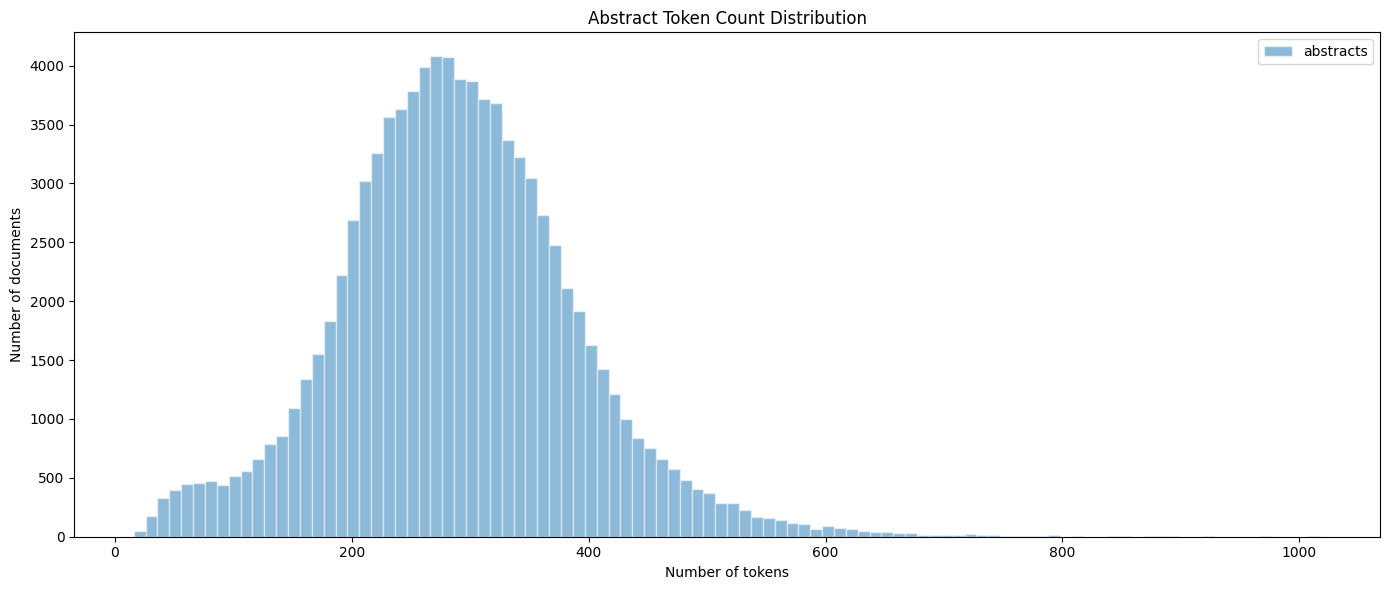

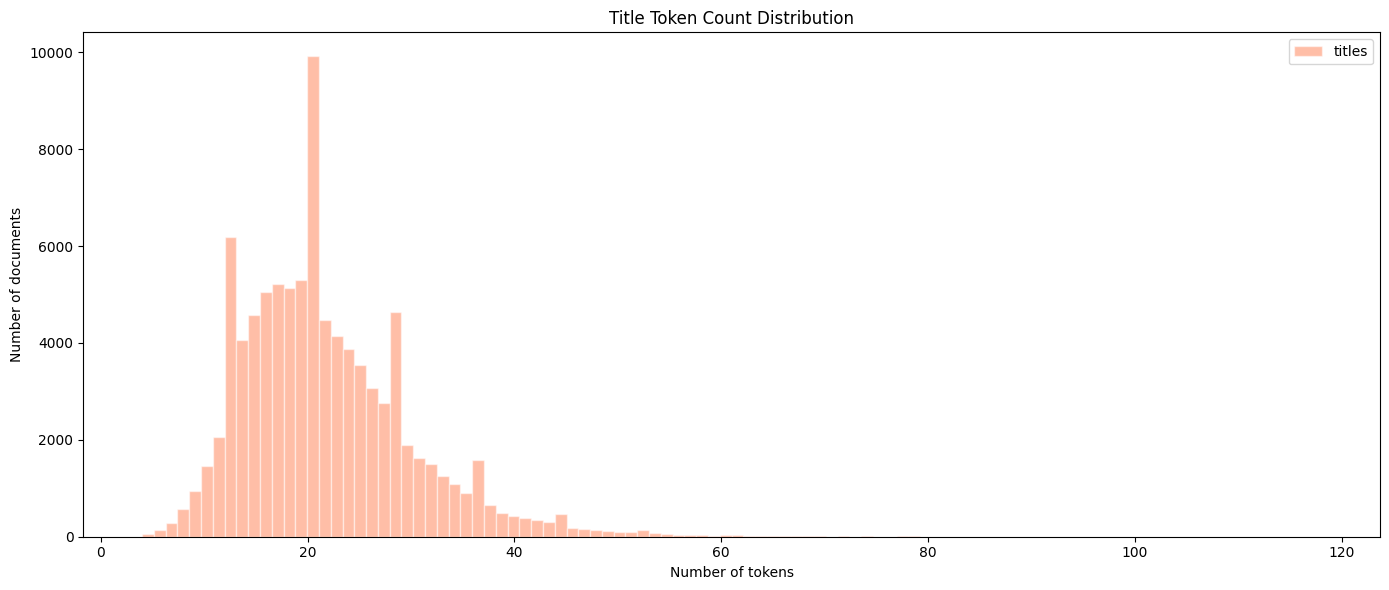

In [40]:
# Plot histogram for abstract tokens
plt.figure(figsize=(14, 6))
plt.hist(df['abstract_tokens'], bins=100, alpha=0.5, label='abstracts', edgecolor='white')
plt.legend()
plt.xlabel('Number of tokens')
plt.ylabel('Number of documents')
plt.title('Abstract Token Count Distribution')
plt.tight_layout()
plt.show()

# Plot histogram for title tokens
plt.figure(figsize=(14, 6))
plt.hist(df['title_tokens'], bins=100, alpha=0.5, label='titles', color='coral', edgecolor='white')
plt.legend()
plt.xlabel('Number of tokens')
plt.ylabel('Number of documents')
plt.title('Title Token Count Distribution')
plt.tight_layout()
plt.show()

## Trim the data

As seen from above, both `title` and `abstract` have a very long tail, indicating outliers. Since out dataset is still comparatively large, we can safely trim the data to remove the outliers, and hopefully improve the performance of our model.

In [41]:
mask = (df['abstract_tokens'].between(128, 512)) & (df['title_tokens'].between(8, 32))
filtered_df = df[mask]
filtered_df.shape

(76792, 5)

In [64]:
filtered_df.to_csv("filtered_data.csv", index=False)

# Bigrams and Trigrams

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import seaborn as sns

# Function to get top n-grams
def get_top_ngrams(corpus, n=None, ngram_range=(1, 1)):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

n = 10

# Get top 20 bigrams and trigrams
top_bigrams = get_top_ngrams(df['abstract'], n=n, ngram_range=(2, 2))
top_trigrams = get_top_ngrams(df['abstract'], n=n, ngram_range=(3, 3))

# Convert to DataFrame for visualization
bigrams_df = pd.DataFrame(top_bigrams, columns=['Bigram', 'Frequency'])
trigrams_df = pd.DataFrame(top_trigrams, columns=['Trigram', 'Frequency'])

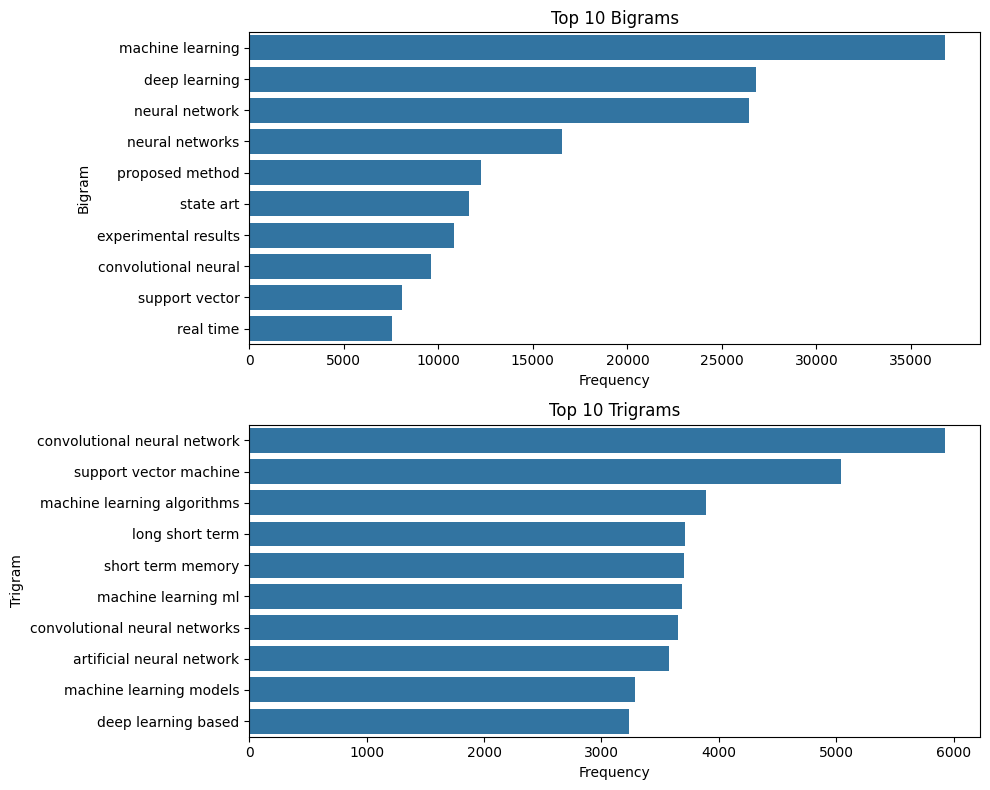

In [43]:
# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot bigrams
sns.barplot(x='Frequency', y='Bigram', data=bigrams_df, ax=axs[0])
axs[0].set_title(f'Top {n} Bigrams')

# Plot trigrams
sns.barplot(x='Frequency', y='Trigram', data=trigrams_df, ax=axs[1])
axs[1].set_title(f'Top {n} Trigrams')

plt.tight_layout()
plt.show()

# Text similarity analysis
## TF-IDF Cosine Similarity

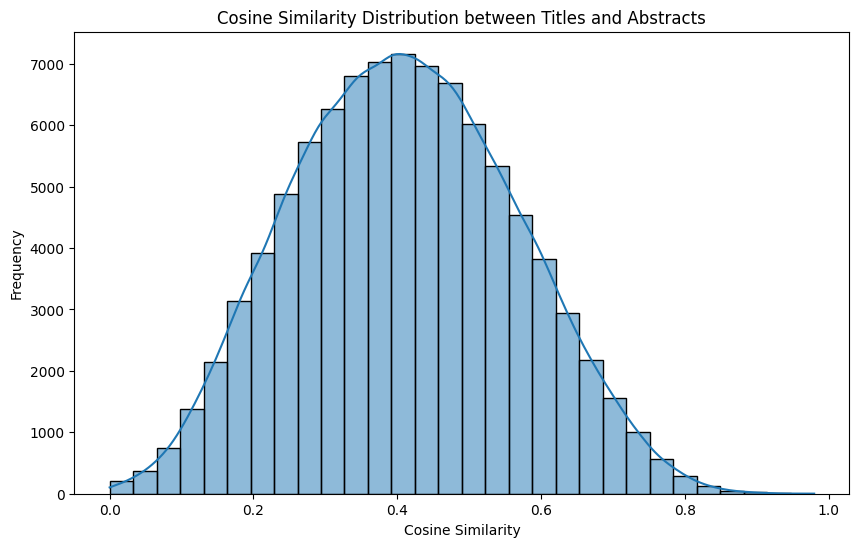

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['abstract'].tolist() + df['title'].tolist())

title_vectors = tfidf_matrix[:len(df)]
abstract_vectors = tfidf_matrix[len(df):]

df["cosine_similarity"] = [
    cosine_similarity(title_vectors[i], abstract_vectors[i])[0][0]
    for i in range(len(df))
]

# Visualize the cosine similarity distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['cosine_similarity'], bins=30, kde=True)
plt.title('Cosine Similarity Distribution between Titles and Abstracts')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()

## Readability & Complexity Analysis with Flesch-Kincaid readability score

In [45]:
import textstat
import seaborn as sns
df['title_readability'] = df['title'].apply(textstat.flesch_reading_ease)
df['abstract_readability'] = df['abstract'].apply(textstat.flesch_reading_ease)

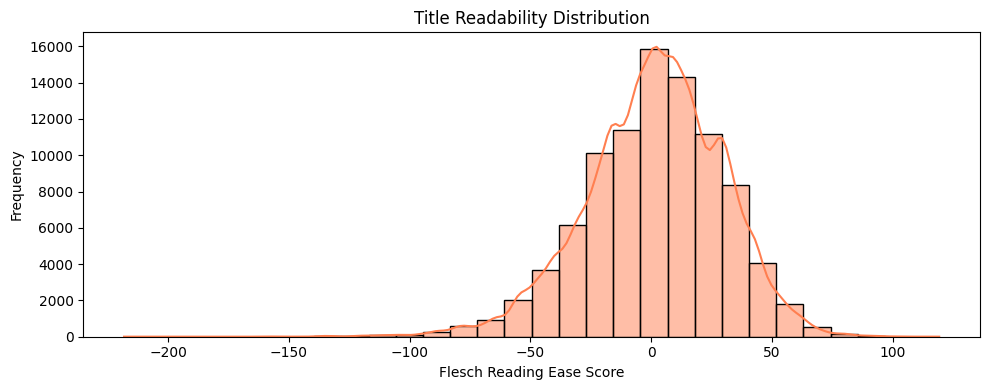

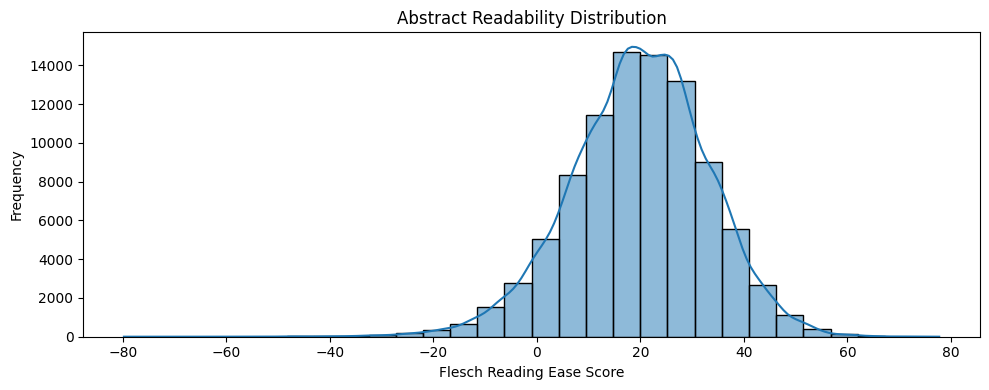

In [46]:
# Plot readability for titles
plt.figure(figsize=(10, 4))
sns.histplot(df['title_readability'], bins=30, kde=True, color='coral')
plt.title('Title Readability Distribution')
plt.xlabel('Flesch Reading Ease Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Plot readability for abstracts
plt.figure(figsize=(10, 4))
sns.histplot(df['abstract_readability'], bins=30, kde=True)
plt.title('Abstract Readability Distribution')
plt.xlabel('Flesch Reading Ease Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [47]:
from wordcloud import WordCloud

# Generate word cloud for abstracts
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(' '.join(df['abstract']))

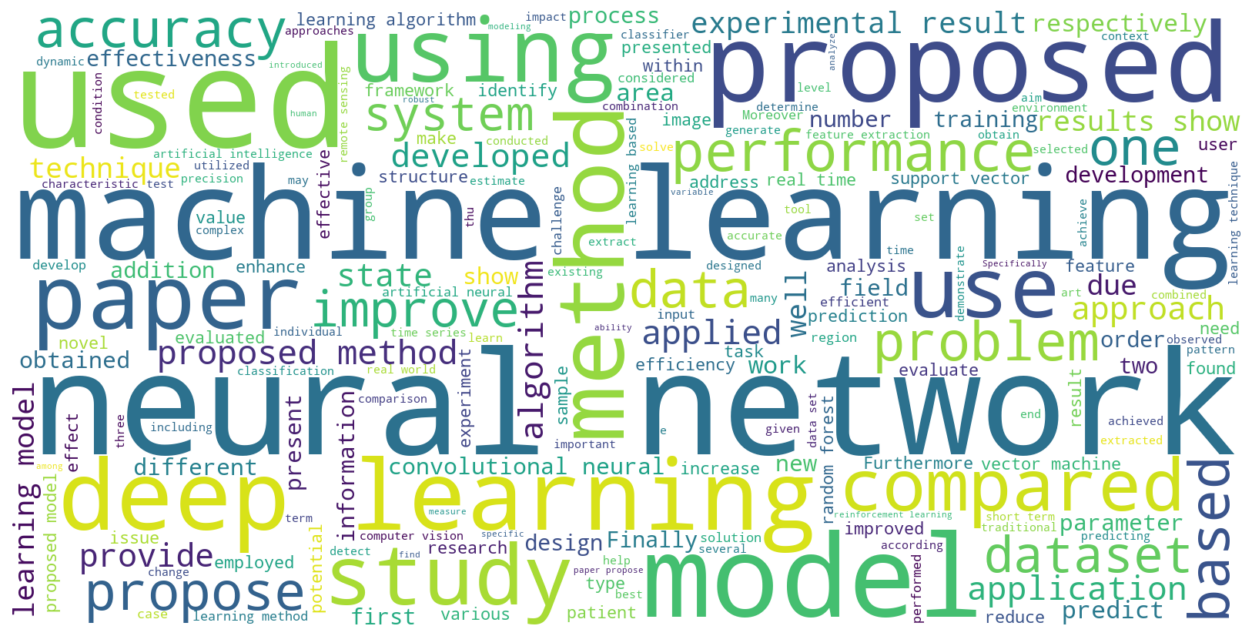

In [48]:
# Plot the word cloud
plt.figure(figsize=(20, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Splitting data

In [49]:
from sklearn.model_selection import train_test_split

# Split the data into train and temp sets
train_df, temp_df = train_test_split(filtered_df, test_size=0.2, random_state=42)

# Split the temp set into validation and test sets
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Display the sizes of the splits
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Train set size: 61433
Validation set size: 7679
Test set size: 7680


### See token distribution on 3 sets

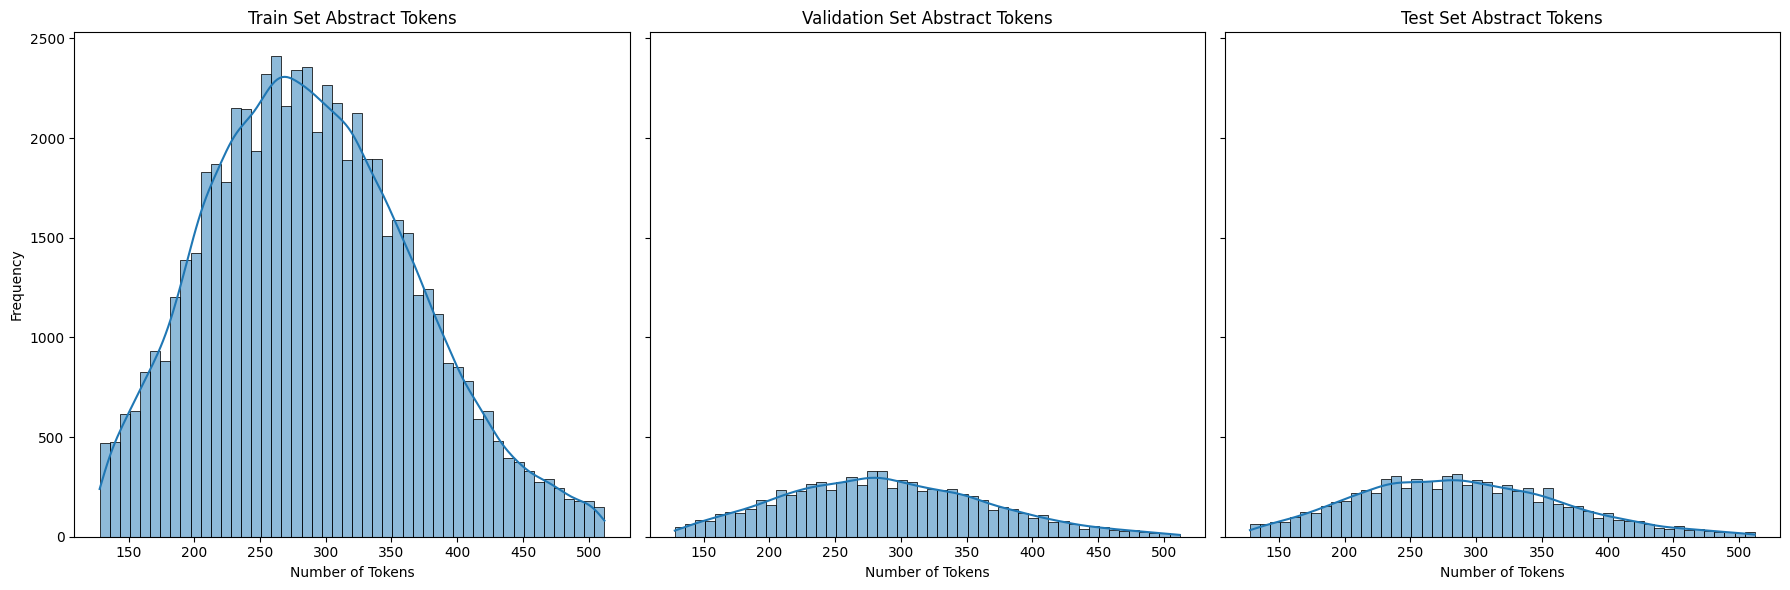

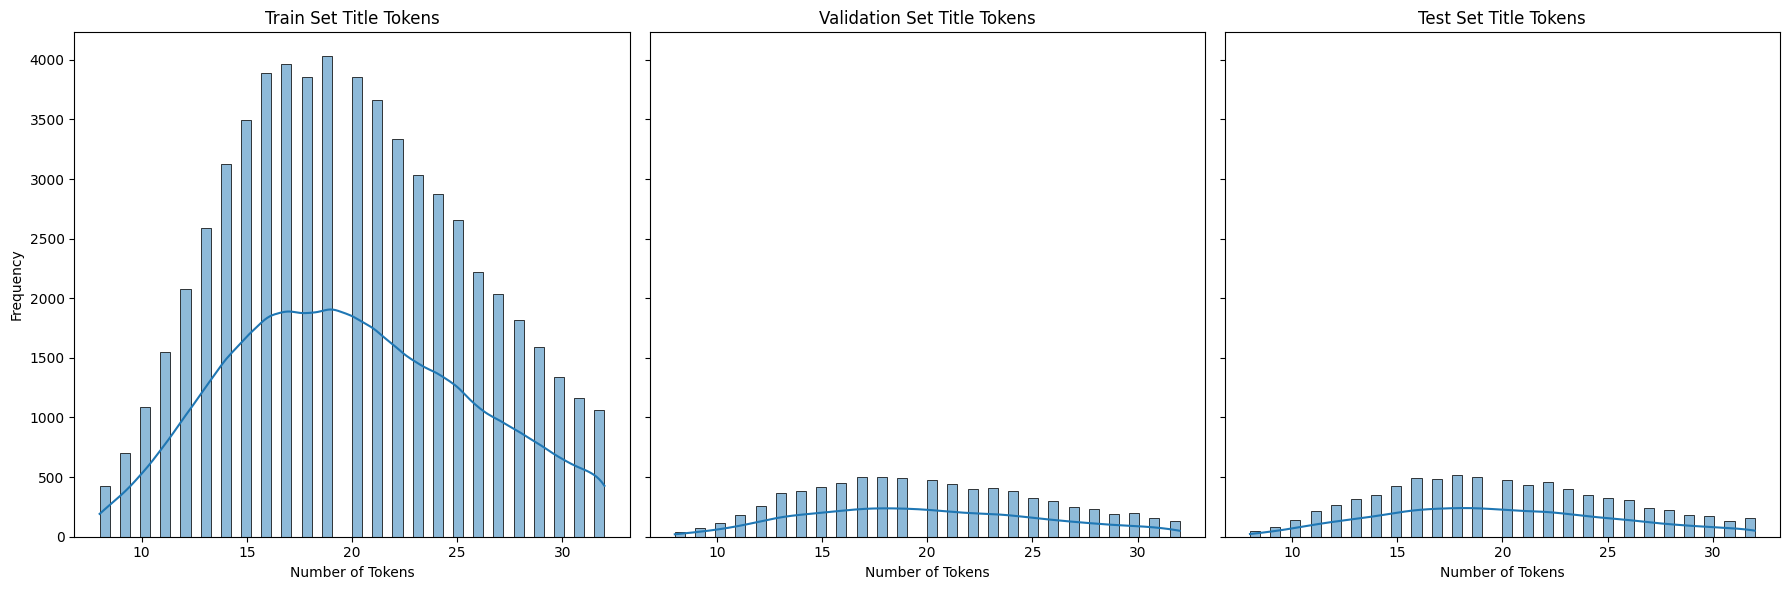

In [50]:

import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

sns.histplot(train_df['abstract_tokens'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Train Set Abstract Tokens')
axes[0].set_xlabel('Number of Tokens')
axes[0].set_ylabel('Frequency')

sns.histplot(val_df['abstract_tokens'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Validation Set Abstract Tokens')
axes[1].set_xlabel('Number of Tokens')

sns.histplot(test_df['abstract_tokens'], bins=50, kde=True, ax=axes[2])
axes[2].set_title('Test Set Abstract Tokens')
axes[2].set_xlabel('Number of Tokens')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

sns.histplot(train_df['title_tokens'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Train Set Title Tokens')
axes[0].set_xlabel('Number of Tokens')
axes[0].set_ylabel('Frequency')

sns.histplot(val_df['title_tokens'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Validation Set Title Tokens')
axes[1].set_xlabel('Number of Tokens')

sns.histplot(test_df['title_tokens'], bins=50, kde=True, ax=axes[2])
axes[2].set_title('Test Set Title Tokens')
axes[2].set_xlabel('Number of Tokens')

plt.tight_layout()
plt.show()

# Building vocabulary on all 3 datasets

In [51]:
from collections import Counter

# Combine all text data from the three datasets and convert to lowercase
train_text = ' '.join(train_df['abstract'].str.lower().tolist() + train_df['title'].str.lower().tolist())
val_text = ' '.join(val_df['abstract'].str.lower().tolist() + val_df['title'].str.lower().tolist())
test_text = ' '.join(test_df['abstract'].str.lower().tolist() + test_df['title'].str.lower().tolist())



# Tokenize and count word frequencies
train_vocab = Counter(train_text.split())
val_vocab = Counter(val_text.split())
test_vocab = Counter(test_text.split())

# Display vocabulary sizes
print(f"Train vocabulary size: {len(train_vocab)}")
print(f"Validation vocabulary size: {len(val_vocab)}")
print(f"Test vocabulary size: {len(test_vocab)}")

# Display the top 10 most common words and their counts for each dataset
print("\nTop 10 most common words in Train dataset:")
print(train_vocab.most_common(10))

print("\nTop 10 most common words in Validation dataset:")
print(val_vocab.most_common(10))

print("\nTop 10 most common words in Test dataset:")
print(test_vocab.most_common(10))

def save_to_txt(data, filename):
    # counter object
    with open(filename, 'w') as f:
        for word, count in data.items():
            f.write(f"\"{word}\"\t{count}\n")

save_to_txt(train_vocab, "./data/train_vocab.txt")
save_to_txt(val_vocab, "./data/val_vocab.txt")
save_to_txt(test_vocab, "./data/test_vocab.txt")

Train vocabulary size: 355538
Validation vocabulary size: 87601
Test vocabulary size: 86800

Top 10 most common words in Train dataset:
[('the', 830978), ('of', 479430), ('and', 450955), ('to', 298078), ('in', 270375), ('a', 245513), ('for', 175932), ('is', 161175), ('on', 111517), ('with', 110131)]

Top 10 most common words in Validation dataset:
[('the', 104403), ('of', 59603), ('and', 56076), ('to', 36973), ('in', 33622), ('a', 30900), ('for', 22012), ('is', 20000), ('on', 14071), ('with', 13762)]

Top 10 most common words in Test dataset:
[('the', 103267), ('of', 59537), ('and', 56164), ('to', 36999), ('in', 33537), ('a', 30766), ('for', 21843), ('is', 20211), ('on', 13777), ('with', 13554)]


In [52]:
train_vc_df = pd.read_csv("./data/train_vocab.txt", sep='\t', names=['word', 'count'])
val_vc_df = pd.read_csv("./data/val_vocab.txt", sep='\t', names=['word', 'count'])
test_vc_df = pd.read_csv("./data/test_vocab.txt", sep='\t', names=['word', 'count'])

In [63]:
# Find words in val_vc_df that are not in train_vc_df
val_not_train_df = val_vc_df[~val_vc_df['word'].isin(train_vc_df['word'])]
test_not_train_df = test_vc_df[~test_vc_df['word'].isin(train_vc_df['word'])]

print(">>> val_not_train\n", val_not_train_df.describe())
print(">>> test_not_train\n", test_not_train_df.describe())

>>> val_not_train
               count
count  30492.000000
mean       1.198609
std        0.679474
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max       16.000000
>>> test_not_train
               count
count  30079.000000
mean       1.204329
std        0.700712
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max       25.000000
